Executando simulações para diferentes níveis de correlação (rho)...
  Simulando para rho = 0.10
  Simulando para rho = 0.20
  Simulando para rho = 0.30
  Simulando para rho = 0.40
  Simulando para rho = 0.50
  Simulando para rho = 0.60
  Simulando para rho = 0.70
  Simulando para rho = 0.80
  Simulando para rho = 0.90


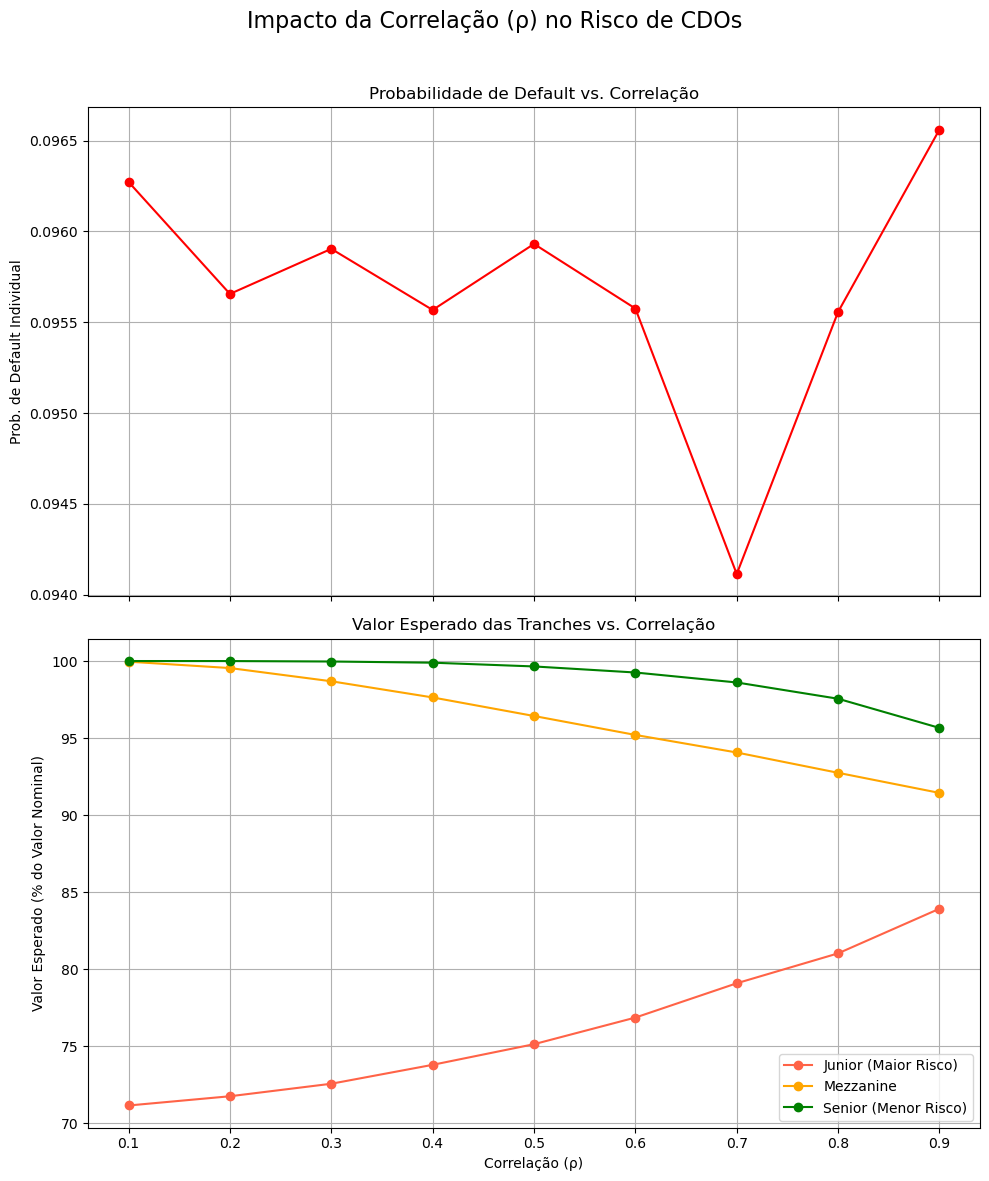

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def run_cdo_simulation(
    N=100,           # Número de empréstimos (bonds) na carteira
    T=5,             # Maturidade dos empréstimos em anos
    mu=0.025,        # Crescimento da renda (ex: crescimento médio do PIB)
    sigma=0.20,      # Volatilidade da renda
    rho=0.2,         # Correlação entre as rendas dos tomadores
    initial_income=100000,
    default_threshold=50000,
    num_simulations=10000,
    dt=1/12          # Passo de tempo (mensal)
):
    """
    Executa a simulação de Monte Carlo para precificar as tranches de um CDO.
    """
    num_steps = int(T / dt)
    
    # 1. Gerar choques aleatórios correlacionados
    # Cria uma matriz de correlação
    corr_matrix = np.full((N, N), rho)
    np.fill_diagonal(corr_matrix, 1)
    
    # Usa a decomposição de Cholesky para correlacionar os choques
    # L * L.T = corr_matrix
    try:
        cholesky_factor = np.linalg.cholesky(corr_matrix)
    except np.linalg.LinAlgError:
        # Se a matriz não for positiva semi-definida, retorna NaN.
        # Isso pode acontecer com rho muito próximo de 1 ou -1 com N grande.
        print(f"Erro na decomposição de Cholesky para rho={rho}. A matriz pode não ser positiva definida.")
        return (np.nan, np.nan, np.nan, np.nan)
        
    # Armazenar os resultados de todas as simulações
    total_defaults = 0
    payoffs_senior = []
    payoffs_mezzanine = []
    payoffs_junior = []

    for _ in range(num_simulations):
        # Gera variáveis aleatórias normais independentes
        Z_uncorrelated = np.random.normal(0, 1, size=(N, num_steps))
        
        # Aplica o fator de Cholesky para obter os choques correlacionados
        Z_correlated = cholesky_factor @ Z_uncorrelated

        # 2. Simular as trajetórias da renda (Movimento Geométrico Browniano)
        income_paths = np.zeros((N, num_steps + 1))
        income_paths[:, 0] = initial_income
        
        for t in range(1, num_steps + 1):
            drift = (mu - 0.5 * sigma**2) * dt
            shock = sigma * np.sqrt(dt) * Z_correlated[:, t-1]
            income_paths[:, t] = income_paths[:, t-1] * np.exp(drift + shock)

        # 3. Determinar os defaults
        # O default ocorre se a renda cair abaixo do limiar em qualquer ponto
        defaults_in_sim = np.any(income_paths < default_threshold, axis=1)
        num_defaults = np.sum(defaults_in_sim)
        total_defaults += num_defaults
        
        # 4. Calcular os payoffs da carteira e das tranches
        P = N - num_defaults  # Payoff total da carteira
        
        tranche_size = N / 3
        losses = num_defaults
        
        # Payoff da Tranche Junior (absorve as primeiras perdas)
        pj_losses = min(losses, tranche_size)
        pj_payoff = tranche_size - pj_losses
        payoffs_junior.append(pj_payoff)
        
        # Payoff da Tranche Mezzanine (absorve as perdas seguintes)
        pm_losses = min(max(0, losses - tranche_size), tranche_size)
        pm_payoff = tranche_size - pm_losses
        payoffs_mezzanine.append(pm_payoff)
        
        # Payoff da Tranche Senior (absorve as últimas perdas)
        ps_losses = min(max(0, losses - 2 * tranche_size), tranche_size)
        ps_payoff = tranche_size - ps_losses
        payoffs_senior.append(ps_payoff)

    # 5. Calcular os valores esperados (médias)
    prob_default_individual = total_defaults / (N * num_simulations)
    expected_pj = np.mean(payoffs_junior)
    expected_pm = np.mean(payoffs_mezzanine)
    expected_ps = np.mean(payoffs_senior)
    
    return prob_default_individual, expected_pj, expected_pm, expected_ps

# --- Script Principal ---
if __name__ == "__main__":
    rho_values = np.arange(0.1, 1.0, 0.1)
    
    results_default_prob = []
    results_pj = []
    results_pm = []
    results_ps = []

    print("Executando simulações para diferentes níveis de correlação (rho)...")
    for rho in rho_values:
        print(f"  Simulando para rho = {rho:.2f}")
        prob, pj, pm, ps = run_cdo_simulation(rho=rho)
        results_default_prob.append(prob)
        results_pj.append(pj)
        results_pm.append(pm)
        results_ps.append(ps)

    # --- Plotar Resultados ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Impacto da Correlação (ρ) no Risco de CDOs', fontsize=16)

    # Gráfico 1: Probabilidade de Default
    ax1.plot(rho_values, results_default_prob, 'o-', color='red')
    ax1.set_ylabel('Prob. de Default Individual')
    ax1.set_title('Probabilidade de Default vs. Correlação')
    ax1.grid(True)

    # Gráfico 2: Valor Esperado das Tranches
    tranche_size = 100 / 3 # Valor máximo de cada tranche
    ax2.plot(rho_values, np.array(results_pj) / tranche_size * 100, 'o-', label='Junior (Maior Risco)', color='tomato')
    ax2.plot(rho_values, np.array(results_pm) / tranche_size * 100, 'o-', label='Mezzanine', color='orange')
    ax2.plot(rho_values, np.array(results_ps) / tranche_size * 100, 'o-', label='Senior (Menor Risco)', color='green')
    ax2.set_xlabel('Correlação (ρ)')
    ax2.set_ylabel('Valor Esperado (% do Valor Nominal)')
    ax2.set_title('Valor Esperado das Tranches vs. Correlação')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()